uncomment if executing in google colab

In [1]:
# ! pip uninstall pyro-ppl
# ! pip install pyro-ppl==1.5.1
# ! unzip fonts.zip 
# ! unzip claptchagen.zip
# ! unzip csis
# ! cp csis.py /usr/local/lib/python3.7/dist-packages/pyro/infer

In [2]:
import random
import string
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time

from torch.autograd import Variable
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from claptchagen.claptcha import Claptcha
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from gmade import GMADE
import matplotlib.pyplot as plt
print(pyro.__version__)

captcha_folder = 'generated_captchas'
captchaHeight = 32
captchaWidth = 100
captchaMarginX = 4
captchaMarginY = 4
batch_size = 10

char_dict = string.digits
USE_CUDA = True
MAX_N = 4 # maximum number of letters in a captcha 
MIN_N = 2 # minimum number of letters in a captcha
MIN_NOISE = 0.01 # minimum noise
MAX_NOISE = 0.99 # maximum noise
smoke_test = False
num_steps = 400 if not smoke_test else 10
TrainingSample = 2000 if not smoke_test else 100 # number of captchas generated for training 
hidden_state_dim = 32

def randomString():
    """
    return a string with <num_char> random letters
    """
    k = random.randint(MIN_N, MAX_N) # sample number of characters
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    
    return space + "".join(rndLetters) + space

def ramdomNoise():
    """
    return a float between MIN_NOISE, MAX_NOISE
    """
    return random.uniform(MIN_NOISE, MAX_NOISE)

def generate_random_captcha(n, save=False):
    """
    generate n random captchas,
    return a list of texts on the captchas
    """
    # Initialize Claptcha object with random text, FreeMono as font, of size
    # 100x30px, using bicubic resampling filter and adding a bit of white noise
    c = Claptcha(randomString, "fonts/FreeSans.ttf", (captchaWidth, captchaHeight), (captchaMarginX, captchaMarginY),
             resample=Image.BILINEAR, noise=0)
    captcha_generated = [ [] for i in range(MAX_N)]
    for i in range(n):
        c.noise = ramdomNoise()
        if save:
            text, _ = c.write(os.path.join(captcha_folder, 'captcha{}.png'.format(i)))
            os.rename(os.path.join(captcha_folder, 'captcha{}.png'.format(i)),os.path.join(captcha_folder, '{}.png'.format(text + "_" + str(i))))
        text, image = c.image
        text = text.strip()
        image = np.array(image)[:, :, 0] # the generator is gray scale, only keep one channel is enough
        captcha_generated[len(text) - 1].append((text, image, c.noise))
    return captcha_generated
    
captcha_generated = generate_random_captcha(TrainingSample, save=False)
for lst in captcha_generated:
    print("number of samples in group", len(lst))
    # print some sample captcha information generated
    for i, t in enumerate(lst):
        print("text", t[0], "captcha shape", t[1].shape, "noise", t[2])
        if i >= 10:
            break

1.7.0
number of samples in group 0
number of samples in group 696
text 00 captcha shape (32, 100) noise 0.8393569095266612
text 31 captcha shape (32, 100) noise 0.1517557835730254
text 37 captcha shape (32, 100) noise 0.9396448451916869
text 92 captcha shape (32, 100) noise 0.9839490987672925
text 82 captcha shape (32, 100) noise 0.49080438504542345
text 92 captcha shape (32, 100) noise 0.3224226851800557
text 93 captcha shape (32, 100) noise 0.2216879688825826
text 61 captcha shape (32, 100) noise 0.6464729253767447
text 69 captcha shape (32, 100) noise 0.9678313731156302
text 53 captcha shape (32, 100) noise 0.651229712145625
text 38 captcha shape (32, 100) noise 0.625680208098838
number of samples in group 645
text 635 captcha shape (32, 100) noise 0.4782796491407698
text 588 captcha shape (32, 100) noise 0.7748195983002336
text 845 captcha shape (32, 100) noise 0.4911348732382226
text 873 captcha shape (32, 100) noise 0.122648929632717
text 934 captcha shape (32, 100) noise 0.87981

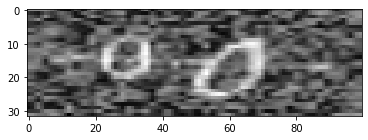

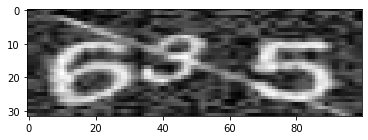

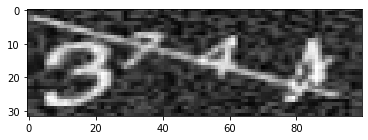

In [3]:
for lst in captcha_generated:
    if len(lst) > 0:
        plt.imshow(lst[0][1], cmap="Greys")
        plt.show()

In [4]:
def render_image(chars, fonts="fonts/FreeSans.ttf", size=(captchaWidth, captchaHeight), 
                 margin=(captchaMarginX, captchaMarginY), resample=Image.BILINEAR, noise=0.3, use_cuda=False):
    #noise = noise.data.item()
    #print(chars, noise)
    pad_spaces = MAX_N - len(chars)
    space = " " * (pad_spaces // 2)
    chars = space + chars + space
    render = Claptcha(chars, fonts, size, margin, resample=resample, noise=noise)

    
    _ , rendered_image = render.image
    rendered_image = np.array(rendered_image)[:,:,0] # the generator is gray scale, only keep one channel is enough
    rendered_image = np.subtract(np.divide(rendered_image, 255), 0.5)
    rendered_image = torch.from_numpy(rendered_image)
    if use_cuda:
        rendered_image = rendered_image.cuda()
    return rendered_image

In [5]:
class CaptchaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, raw_captchas, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.raw_captchas = raw_captchas
        self.transform = transform

    def __len__(self):
        return len(self.raw_captchas)

    def __getitem__(self, idx):
        label = self.raw_captchas[idx][0]
        image = self.raw_captchas[idx][1]
        noise = self.raw_captchas[idx][2]
        
        image = np.subtract(np.divide(image, 255), 0.5)
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        return label, image, noise

In [6]:
def make_loarders(BATCH_SIZE, raw_samples):
    dataloaders = [] # dataloaders for different num of char
    for lst in raw_samples:
        if lst:
            ds = CaptchaDataset(lst)
            dataloader = DataLoader(ds, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=0, drop_last=True)
            dataloaders.append(dataloader)
    return dataloaders

def make_batches(dataloaders):
    all_batches = []
    for dl in dataloaders:
        for i_batch, sample in enumerate(dl):
            all_batches.append(sample)
    random.shuffle(all_batches)
    random.shuffle(all_batches)
    return all_batches

TrainLoaders = make_loarders(BATCH_SIZE=batch_size, raw_samples=captcha_generated)

In [7]:
class NoiseNet(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(NoiseNet, self).__init__()
        
        self.img_size = img_size
        self.fc0 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.fc1 = nn.Linear(img_size[0] * img_size[1], 1024)
        
        self.fc2 = nn.Linear(1024, 1024)
        self.fc20 = nn.Linear(1024, img_size[0] * img_size[1])
        self.fc21 = nn.Linear(img_size[0] * img_size[1], out_size)
        self.softplus = nn.Softplus()
    
    def forward(self, img):
        BS = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1])
        hidden = F.relu(self.fc0(img))
        hidden = self.fc1(hidden)
        # mean of noise, used in normal distribution
        noise_map = self.fc20(F.relu(self.fc2(F.relu(hidden))))
        mean =  self.fc21(F.relu(noise_map))
        # std used in normal distribution
        sigma = torch.tensor([[1e-8] for _ in range(BS)]).float()
        if USE_CUDA:
            sigma = sigma.cuda()
        return mean, sigma, noise_map

In [8]:
class NumNet(nn.Module):
    def __init__(self, img_size, out_size = 3):
        """
        Network for learning N, number of letters in a captcha
        """
        super(NumNet, self).__init__()
        self.neural_net = nn.Sequential(
            nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1] * 2),
            nn.ReLU(),
            nn.Linear(img_size[0] * img_size[1] * 2, 256),
            nn.ReLU(),
            nn.Linear(256, out_size),
            nn.LogSoftmax(dim=1))
  
    def forward(self, img):
        img = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
        prob = self.neural_net(img)
        return prob

In [9]:
class InputEmbedding(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(InputEmbedding, self).__init__()
        self.img_size = img_size
        
        # observe layers
        self.nnfc = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.convBN1 = nn.BatchNorm2d(64)
        self.convBN2 = nn.BatchNorm2d(64)
        self.convBN3 = nn.BatchNorm2d(64)

    def forward(self, img, noise_map):
        
        BATCH_SIZE = img.shape[0]
        img = torch.reshape(img, (BATCH_SIZE, 1, self.img_size[0], self.img_size[1]))

        img = self.pool(F.relu(self.convBN1(self.conv1(img))))
        img = self.pool(F.relu(self.convBN2(self.conv2(img))))
        img = self.pool(F.relu(self.convBN3(self.conv3(img))))
        
        img = torch.reshape(img, (BATCH_SIZE, 1280))
        return img

In [10]:
class CharNetSingle(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(CharNetSingle, self).__init__()
        self.img_size = img_size
        
        # branches
        self.pfc1 = nn.Linear(1280 + hidden_state_dim + 1, 2048)
        self.pfc2 = nn.Linear(2048, 1024)
        self.pfc3 = nn.Linear(1024, 1024)
        self.pfc4 = nn.Linear(1024, output_size)

    def forward(self, img_embedded, hid, noise_batch):
        
        BATCH_SIZE = img_embedded.shape[0]

        img = torch.cat((img_embedded, hid, noise_batch), 1)
        
        out = F.relu(self.pfc1(img))
        out = F.relu(self.pfc2(out))
        out = F.relu(self.pfc3(out))
        out = self.pfc4(out)
        out = F.log_softmax(out, dim=1)
        
        return out

In [11]:
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list, 1)
        #print(input_x, input_x.shape)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)

In [12]:
def inference(t, use_cuda=False):
    """
    one epoch of inference (iterate the training set once)
    """
    start = time.time()
    loss = 0
    length = TrainingSample
    loss_group = []
    all_batches = make_batches(TrainLoaders)
    for i_batch, sample_batched in enumerate(all_batches):
        
        img = sample_batched[1]
        if use_cuda:
            img = img.cuda()
        IMG = {"captcha" : img}
        imme_loss = csis.step(observations=IMG)
        loss += imme_loss / length

    print("loss at epoch {} is {}".format(t, loss), end="; ")
    print("Epoch takes", round(time.time()- start), "seconds")
    return loss

In [13]:
test_accuracies = []
test_char_accuracies = []
test_noise_differences = []
train_accuracies = []
train_char_accuracies = []
train_noise_differences = []

def test(n = 0, use_train=False, verbose=False, use_cuda=False):
    """
    benchmarking performance on customized or training set
    """
    global test_accuracies, test_char_accuracies, train_accuracies, train_char_accuracies, train_noise_differences, test_noise_differences
    if use_train:
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=captcha_generated)
    else:
        test_captcha_generated = generate_random_captcha(n, save=False)
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=test_captcha_generated)
    
    total_correct = 0
    char_correct = 0
    total_char = 0
    all_batches = make_batches(TestLoaders)
    noise_difference = 0
    for i_batch, t in enumerate(all_batches):

        label = t[0][0]
        gt_noise = t[2][0]
        img = t[1]

        if use_cuda:
            img = img.cuda()
        
        IMG = {"captcha" : img}
        
        posterior = csis.run(observations=IMG)
        marginal_num = pyro.infer.EmpiricalMarginal(posterior, "num_char")
        marginal_noise = pyro.infer.EmpiricalMarginal(posterior, "noise")
        with torch.no_grad():

            N_index = marginal_num()
            N = N_index + captchaModel.num_char_domain[0]
            noise = captchaModel._map_to_noise_range(marginal_noise()[0])
            sampled_chars = []
            
            # sample characters one by one
            for i in range(N):
                marginal_char = pyro.infer.EmpiricalMarginal(posterior, "char_{}".format(i))()[0]
                if use_cuda:
                    marginal_char.cpu()
                sampled_chars.append(marginal_char)
        
        chars = ""
        for i in range(len(sampled_chars)):
            c = sampled_chars[i]
            chars +=  captchaModel.char_dict[c]
        correct = 0
        
        for p_char, t_char in zip(chars, label):
            if p_char == t_char:
                correct += 1
        noise_difference += abs(float(noise) - float(gt_noise))
        if not verbose:
            print("N_predicted:", int(N), "| Actual N:", len(label), "| Predicted Noise:", round(float(noise), 3), "| Actual Noise:", round(float(gt_noise), 3), "| Predicted Text:", chars, "| Actual Text:", label, "| Correct:", correct)
        if correct == len(label) and int(N) == len(label):
            total_correct += 1
        char_correct += correct
        total_char += len(label)
    num_test_samples = i_batch + 1
    accuracy = total_correct / num_test_samples
    char_accuracy = char_correct / total_char
 
    
    noise_difference = noise_difference / num_test_samples
    if use_train:
        train_accuracies.append(accuracy)
        train_char_accuracies.append(char_accuracy)
        train_noise_differences.append(noise_difference)
    elif n > 10:
        test_accuracies.append(accuracy)
        test_char_accuracies.append(char_accuracy)
        test_noise_differences.append(noise_difference)
    print("use_train =", use_train, "AVG Noise Difference:", noise_difference, "Total correct:", total_correct, "accuracy:{}/{}=".format(total_correct, num_test_samples), accuracy, "char_accuracy:{}/{}=".format(char_correct, total_char), char_accuracy)


In [14]:

losses  = []
def test_cycle(use_cuda):
    
    # disable dropout
#     captchaModel.numNet.eval()
#     captchaModel.charNetSingle.eval()
    test(use_train=True, verbose=True, use_cuda=use_cuda)
    test(1000, use_train=False, verbose=True, use_cuda=use_cuda)
    #test(10, use_train=True, verbose=False, use_cuda=use_cuda)
    test(10, use_train=False, verbose=False, use_cuda=use_cuda)
    # enable dropout
#     captchaModel.numNet.train()
#     captchaModel.charNetSingle.train()

def optimize(start_epoch=1, use_cuda=False):
    """
    Training/Inferencing Stage
    """
    loss_sequence = []
    pause = 5
    save_pause = 10
    print("Optimizing...")
    for t in range(start_epoch, num_steps + 1):
        L = inference(t, use_cuda)
        loss_sequence.append(L)
        losses.append(L)
        if (t % pause == 0) and (t > 0):
            test_cycle(use_cuda=use_cuda)
        #if (t % save_pause == 0) and (t > 0):
        #    save_and_download_checkpoints("branches-1-no-var-no-tanh_model.pt", "branches-1-no-var-no-tanh_optim.pt", "branches-1-no-var-no-tanh_param_store.pt")
    plt.plot(loss_sequence)
    plt.title("loss")
    plt.show()

In [15]:
# saves the model and optimizer states to disk
def save_checkpoint(currentModel, currentOptimzier, save_model, save_opt, save_param_store):
    print("saving model to %s..." % save_model)
    torch.save(currentModel.state_dict(), save_model)
    print("saving optimizer states to %s..." % save_opt)
    currentOptimzier.save(save_opt)
    print("saving pyro pram store states to %s..." % save_param_store)
    pyro.get_param_store().save(save_param_store)
    print("done saving checkpoints to disk.")

# loads the model and optimizer states from disk
def load_checkpoint(myModel, myOptimzer, load_model, load_opt, load_param_store):
    pyro.clear_param_store()
    print("loading model from %s..." % load_model)
    myModel.load_state_dict(torch.load(load_model))
    print("loading optimizer states from %s..." % load_opt)
    myOptimzer.load(load_opt)
    print("loading pyro pram store states from %s..." % load_param_store)
    pyro.get_param_store().load(load_param_store)
    print("done loading states.")
    pyro.module("guide", myModel, update_module_params=True)

def save_and_download_checkpoints(save_model, save_opt, save_param_store):
    save_checkpoint(captchaModel, optimiser, save_model, save_opt, save_param_store)
def save_metric_to_disk(file_path):
    import json
    save_dict = {
        "test_accuracies" : test_accuracies,
        "test_char_accuracies" : test_char_accuracies,
        "test_noise_differences" : test_noise_differences,
        "train_accuracies"  : train_accuracies,
        "train_char_accuracies"  : train_char_accuracies,
        "train_noise_differences" : train_char_accuracies
    }
    with open(file_path, 'w') as fout:
        json.dump(save_dict, fout)

all_dependencies num_char ['img']
all_dependencies noise ['img']
all_sets [(0,)]
input_ordering [0]
out_sets [(0,), (0,)]
out_orderings [0, 0]
hid_orderings size 3200
num hid layers: 3
expanded_input_ordering size 3200
expanded_output_ordering size 5
number of levels: 1
input_levels [['img']]
out_levels [['num_char', 'noise']]
Optimizing...


C:\Users\frank\anaconda3\envs\pyro-env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss at epoch 1 is 7.346796535730361; Epoch takes 112 seconds
loss at epoch 2 is 6.179879997253417; Epoch takes 111 seconds
loss at epoch 3 is 5.710323132276537; Epoch takes 113 seconds
loss at epoch 4 is 5.313277024507525; Epoch takes 111 seconds
loss at epoch 5 is 4.972035667896266; Epoch takes 111 seconds
use_train = True AVG Noise Difference: 0.09862513572185501 Total correct: 54 accuracy:54/2000= 0.027 char_accuracy:1248/5963= 0.20929062552406508
use_train = False AVG Noise Difference: 0.10121216174566695 Total correct: 14 accuracy:14/1000= 0.014 char_accuracy:608/2999= 0.20273424474824941
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.385 | Actual Noise: 0.484 | Predicted Text: 73 | Actual Text: 73 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.442 | Actual Noise: 0.391 | Predicted Text: 94 | Actual Text: 84 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.327 | Actual Noise: 0.086 | Predicted Text: 38 | Actual Text: 30 | Correct: 1
N_predicted: 2

loss at epoch 22 is 0.30700691826632837; Epoch takes 112 seconds
loss at epoch 23 is 0.15747271657820971; Epoch takes 111 seconds
loss at epoch 24 is 0.11395571431499596; Epoch takes 112 seconds
loss at epoch 25 is -0.06742942671178026; Epoch takes 112 seconds
use_train = True AVG Noise Difference: 0.04518519539941995 Total correct: 1019 accuracy:1019/2000= 0.5095 char_accuracy:4664/5963= 0.7821566325674996
use_train = False AVG Noise Difference: 0.04542424761906108 Total correct: 519 accuracy:519/1000= 0.519 char_accuracy:2396/3025= 0.7920661157024793
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.736 | Actual Noise: 0.804 | Predicted Text: 264 | Actual Text: 264 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.846 | Actual Noise: 0.9 | Predicted Text: 4412 | Actual Text: 4412 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.303 | Actual Noise: 0.287 | Predicted Text: 208 | Actual Text: 208 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.7

loss at epoch 42 is -0.7402277959137812; Epoch takes 113 seconds
loss at epoch 43 is -0.7921831716820599; Epoch takes 112 seconds
loss at epoch 44 is -0.7886793356119655; Epoch takes 112 seconds
loss at epoch 45 is -0.7840855905633657; Epoch takes 112 seconds
use_train = True AVG Noise Difference: 0.04270840088708062 Total correct: 1505 accuracy:1505/2000= 0.7525 char_accuracy:5413/5963= 0.9077645480462855
use_train = False AVG Noise Difference: 0.04341065391990887 Total correct: 730 accuracy:730/1000= 0.73 char_accuracy:2733/3040= 0.8990131578947368
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.616 | Actual Noise: 0.588 | Predicted Text: 5318 | Actual Text: 5318 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.228 | Actual Noise: 0.179 | Predicted Text: 44 | Actual Text: 44 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.189 | Actual Noise: 0.157 | Predicted Text: 036 | Actual Text: 036 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.793

loss at epoch 63 is -0.9919038833649826; Epoch takes 112 seconds
loss at epoch 64 is -0.9503166600234404; Epoch takes 113 seconds
loss at epoch 65 is -0.9305747183334201; Epoch takes 112 seconds
use_train = True AVG Noise Difference: 0.03523402677819672 Total correct: 1672 accuracy:1672/2000= 0.836 char_accuracy:5610/5963= 0.9408016099278886
use_train = False AVG Noise Difference: 0.0349745597028478 Total correct: 837 accuracy:837/1000= 0.837 char_accuracy:2806/2981= 0.9412948674941295
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.295 | Actual Noise: 0.321 | Predicted Text: 68 | Actual Text: 68 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.329 | Actual Noise: 0.339 | Predicted Text: 7803 | Actual Text: 7803 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.848 | Actual Noise: 0.914 | Predicted Text: 56 | Actual Text: 56 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.287 | Actual Noise: 0.297 | Predicted Text: 5191 | Actual Text: 5191 | 

loss at epoch 83 is -1.029884898320772; Epoch takes 112 seconds
loss at epoch 84 is -0.9899389059571547; Epoch takes 112 seconds
loss at epoch 85 is -1.0406666312972084; Epoch takes 112 seconds
use_train = True AVG Noise Difference: 0.03360114895934618 Total correct: 1766 accuracy:1766/2000= 0.883 char_accuracy:5718/5963= 0.9589132986751635
use_train = False AVG Noise Difference: 0.032207970322865695 Total correct: 880 accuracy:880/1000= 0.88 char_accuracy:2867/2991= 0.9585422935473086
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.201 | Actual Noise: 0.149 | Predicted Text: 68 | Actual Text: 68 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.77 | Actual Noise: 0.749 | Predicted Text: 38 | Actual Text: 38 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.656 | Actual Noise: 0.678 | Predicted Text: 5063 | Actual Text: 0063 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.878 | Actual Noise: 0.9 | Predicted Text: 13 | Actual Text: 13 | Correct

loss at epoch 103 is -1.1398373656105254; Epoch takes 111 seconds
loss at epoch 104 is -1.1016015069093548; Epoch takes 112 seconds
loss at epoch 105 is -1.0771794741795162; Epoch takes 111 seconds
use_train = True AVG Noise Difference: 0.03404669347643538 Total correct: 1783 accuracy:1783/2000= 0.8915 char_accuracy:5745/5963= 0.9634412208619823
use_train = False AVG Noise Difference: 0.034820039384417203 Total correct: 885 accuracy:885/1000= 0.885 char_accuracy:2928/3052= 0.9593709043250328
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.867 | Actual Noise: 0.874 | Predicted Text: 93 | Actual Text: 93 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.235 | Actual Noise: 0.232 | Predicted Text: 3765 | Actual Text: 3765 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.872 | Actual Noise: 0.967 | Predicted Text: 6430 | Actual Text: 6440 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.311 | Actual Noise: 0.322 | Predicted Text: 64 | Actual Text:

loss at epoch 123 is -1.1458367692800822; Epoch takes 111 seconds
loss at epoch 124 is -1.1794067385550595; Epoch takes 111 seconds
loss at epoch 125 is -1.1265910664953407; Epoch takes 111 seconds
use_train = True AVG Noise Difference: 0.034167860397206054 Total correct: 1792 accuracy:1792/2000= 0.896 char_accuracy:5759/5963= 0.9657890323662586
use_train = False AVG Noise Difference: 0.03428826275274288 Total correct: 906 accuracy:906/1000= 0.906 char_accuracy:2936/3027= 0.9699372315824248
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.222 | Actual Noise: 0.169 | Predicted Text: 458 | Actual Text: 458 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.747 | Actual Noise: 0.773 | Predicted Text: 11 | Actual Text: 11 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.191 | Actual Noise: 0.133 | Predicted Text: 94 | Actual Text: 94 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.464 | Actual Noise: 0.486 | Predicted Text: 6404 | Actual Text: 6404

loss at epoch 143 is -1.178975539203733; Epoch takes 111 seconds
loss at epoch 144 is -1.1318941069841382; Epoch takes 112 seconds
loss at epoch 145 is -1.1521170479319987; Epoch takes 111 seconds
use_train = True AVG Noise Difference: 0.031209861390873662 Total correct: 1835 accuracy:1835/2000= 0.9175 char_accuracy:5800/5963= 0.9726647660573536
use_train = False AVG Noise Difference: 0.0318719078308045 Total correct: 927 accuracy:927/1000= 0.927 char_accuracy:2941/3012= 0.9764276228419655
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.311 | Actual Noise: 0.281 | Predicted Text: 81 | Actual Text: 81 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.838 | Actual Noise: 0.866 | Predicted Text: 476 | Actual Text: 476 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.817 | Actual Noise: 0.815 | Predicted Text: 833 | Actual Text: 833 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.744 | Actual Noise: 0.764 | Predicted Text: 413 | Actual Text: 413 

loss at epoch 163 is -1.1534390702489765; Epoch takes 111 seconds
loss at epoch 164 is -1.1989828836284575; Epoch takes 111 seconds
loss at epoch 165 is -1.1463919691457412; Epoch takes 111 seconds
use_train = True AVG Noise Difference: 0.035134785457973904 Total correct: 1858 accuracy:1858/2000= 0.929 char_accuracy:5826/5963= 0.9770249874224384
use_train = False AVG Noise Difference: 0.035443528154729835 Total correct: 912 accuracy:912/1000= 0.912 char_accuracy:2946/3032= 0.9716358839050132
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.161 | Actual Noise: 0.058 | Predicted Text: 90 | Actual Text: 90 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.263 | Actual Noise: 0.22 | Predicted Text: 43 | Actual Text: 43 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.234 | Actual Noise: 0.223 | Predicted Text: 071 | Actual Text: 071 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.808 | Actual Noise: 0.796 | Predicted Text: 7719 | Actual Text: 7719

loss at epoch 183 is -1.210865220926702; Epoch takes 111 seconds
loss at epoch 184 is -1.2148495798297232; Epoch takes 111 seconds
loss at epoch 185 is -1.2118200928904121; Epoch takes 111 seconds
use_train = True AVG Noise Difference: 0.031616608790301634 Total correct: 1881 accuracy:1881/2000= 0.9405 char_accuracy:5844/5963= 0.9800436022136508
use_train = False AVG Noise Difference: 0.03202115845241655 Total correct: 946 accuracy:946/1000= 0.946 char_accuracy:2913/2970= 0.9808080808080808
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.863 | Actual Noise: 0.985 | Predicted Text: 009 | Actual Text: 009 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.717 | Actual Noise: 0.732 | Predicted Text: 56 | Actual Text: 56 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.795 | Actual Noise: 0.805 | Predicted Text: 81 | Actual Text: 31 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.739 | Actual Noise: 0.752 | Predicted Text: 627 | Actual Text: 627 |

loss at epoch 203 is -1.219896159310825; Epoch takes 111 seconds
loss at epoch 204 is -1.2318237792383882; Epoch takes 111 seconds
loss at epoch 205 is -1.227083308232948; Epoch takes 111 seconds
use_train = True AVG Noise Difference: 0.03306639256076817 Total correct: 1877 accuracy:1877/2000= 0.9385 char_accuracy:5843/5963= 0.9798759013919168
use_train = False AVG Noise Difference: 0.03233260357423949 Total correct: 940 accuracy:940/1000= 0.94 char_accuracy:2947/3009= 0.9793951478896643
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.155 | Actual Noise: 0.011 | Predicted Text: 12 | Actual Text: 12 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.321 | Actual Noise: 0.306 | Predicted Text: 1945 | Actual Text: 1945 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.915 | Actual Noise: 0.956 | Predicted Text: 735 | Actual Text: 735 | Correct: 3
N_predicted: 2 | Actual N: 3 | Predicted Noise: 0.84 | Actual Noise: 0.818 | Predicted Text: 02 | Actual Text: 029 | 

loss at epoch 223 is -1.2357442528950056; Epoch takes 110 seconds
loss at epoch 224 is -1.222964268428274; Epoch takes 110 seconds
loss at epoch 225 is -1.2489852797449132; Epoch takes 110 seconds
use_train = True AVG Noise Difference: 0.032207983638697354 Total correct: 1894 accuracy:1894/2000= 0.947 char_accuracy:5858/5963= 0.9823914137179273
use_train = False AVG Noise Difference: 0.03438123520919479 Total correct: 950 accuracy:950/1000= 0.95 char_accuracy:2952/3001= 0.9836721092969011
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.531 | Actual Noise: 0.501 | Predicted Text: 20 | Actual Text: 20 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.838 | Actual Noise: 0.899 | Predicted Text: 2739 | Actual Text: 2739 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.897 | Actual Noise: 0.982 | Predicted Text: 979 | Actual Text: 979 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.382 | Actual Noise: 0.37 | Predicted Text: 297 | Actual Text: 297 

loss at epoch 243 is -1.2332480538077648; Epoch takes 111 seconds
loss at epoch 244 is -1.2354734322316958; Epoch takes 110 seconds
loss at epoch 245 is -1.2565085031953644; Epoch takes 110 seconds
use_train = True AVG Noise Difference: 0.02861835451173523 Total correct: 1900 accuracy:1900/2000= 0.95 char_accuracy:5857/5963= 0.9822237128961931
use_train = False AVG Noise Difference: 0.028341338257511967 Total correct: 953 accuracy:953/1000= 0.953 char_accuracy:2981/3022= 0.986432825943084
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.778 | Actual Noise: 0.734 | Predicted Text: 1566 | Actual Text: 1566 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.769 | Actual Noise: 0.802 | Predicted Text: 82 | Actual Text: 82 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.177 | Actual Noise: 0.097 | Predicted Text: 7115 | Actual Text: 7115 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.492 | Actual Noise: 0.518 | Predicted Text: 010 | Actual Text: 0

loss at epoch 263 is -1.2734464631304148; Epoch takes 110 seconds
loss at epoch 264 is -1.2496908617243165; Epoch takes 110 seconds
loss at epoch 265 is -1.2661111106649041; Epoch takes 110 seconds
use_train = True AVG Noise Difference: 0.02780819976636936 Total correct: 1903 accuracy:1903/2000= 0.9515 char_accuracy:5865/5963= 0.9835653194700654
use_train = False AVG Noise Difference: 0.027843356235613296 Total correct: 951 accuracy:951/1000= 0.951 char_accuracy:2911/2960= 0.9834459459459459
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.271 | Actual Noise: 0.278 | Predicted Text: 393 | Actual Text: 393 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.845 | Actual Noise: 0.916 | Predicted Text: 4307 | Actual Text: 4307 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.58 | Actual Noise: 0.593 | Predicted Text: 34 | Actual Text: 34 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.421 | Actual Noise: 0.445 | Predicted Text: 185 | Actual Text: 1

loss at epoch 283 is -1.235757547185756; Epoch takes 110 seconds
loss at epoch 284 is -1.2929466953016826; Epoch takes 110 seconds
loss at epoch 285 is -1.281806367491022; Epoch takes 110 seconds
use_train = True AVG Noise Difference: 0.028577337462183196 Total correct: 1913 accuracy:1913/2000= 0.9565 char_accuracy:5884/5963= 0.9867516350830119
use_train = False AVG Noise Difference: 0.028634911207594146 Total correct: 938 accuracy:938/1000= 0.938 char_accuracy:2951/3010= 0.9803986710963455
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.718 | Actual Noise: 0.738 | Predicted Text: 454 | Actual Text: 454 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.361 | Actual Noise: 0.341 | Predicted Text: 319 | Actual Text: 319 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.824 | Actual Noise: 0.855 | Predicted Text: 26 | Actual Text: 26 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.249 | Actual Noise: 0.238 | Predicted Text: 19 | Actual Text: 19 |

loss at epoch 304 is -1.2880342034101482; Epoch takes 110 seconds
loss at epoch 305 is -1.2526003636755054; Epoch takes 110 seconds
use_train = True AVG Noise Difference: 0.02959669107408517 Total correct: 1890 accuracy:1890/2000= 0.945 char_accuracy:5857/5963= 0.9822237128961931
use_train = False AVG Noise Difference: 0.03125629907735441 Total correct: 953 accuracy:953/1000= 0.953 char_accuracy:2941/2985= 0.9852596314907873
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.177 | Actual Noise: 0.116 | Predicted Text: 22 | Actual Text: 22 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.52 | Actual Noise: 0.535 | Predicted Text: 19 | Actual Text: 19 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.831 | Actual Noise: 0.828 | Predicted Text: 09 | Actual Text: 09 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.845 | Actual Noise: 0.861 | Predicted Text: 002 | Actual Text: 002 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.889 | Ac

loss at epoch 325 is -1.279277078293264; Epoch takes 110 seconds
use_train = True AVG Noise Difference: 0.028260457468716603 Total correct: 1913 accuracy:1913/2000= 0.9565 char_accuracy:5875/5963= 0.9852423276874057
use_train = False AVG Noise Difference: 0.029019378537595696 Total correct: 965 accuracy:965/1000= 0.965 char_accuracy:2968/3004= 0.9880159786950732
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.413 | Actual Noise: 0.403 | Predicted Text: 859 | Actual Text: 859 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.212 | Actual Noise: 0.234 | Predicted Text: 160 | Actual Text: 160 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.153 | Actual Noise: 0.084 | Predicted Text: 729 | Actual Text: 729 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.909 | Actual Noise: 0.966 | Predicted Text: 93 | Actual Text: 93 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.736 | Actual Noise: 0.762 | Predicted Text: 986 | Actual Text: 986 

loss at epoch 345 is -1.2727600119896227; Epoch takes 110 seconds
use_train = True AVG Noise Difference: 0.0275829417361941 Total correct: 1931 accuracy:1931/2000= 0.9655 char_accuracy:5897/5963= 0.9889317457655542
use_train = False AVG Noise Difference: 0.027037242232696036 Total correct: 963 accuracy:963/1000= 0.963 char_accuracy:2942/2976= 0.9885752688172043
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.655 | Actual Noise: 0.652 | Predicted Text: 96 | Actual Text: 96 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.752 | Actual Noise: 0.789 | Predicted Text: 4223 | Actual Text: 4223 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.517 | Actual Noise: 0.545 | Predicted Text: 57 | Actual Text: 57 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.141 | Actual Noise: 0.057 | Predicted Text: 89 | Actual Text: 89 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.54 | Actual Noise: 0.533 | Predicted Text: 4845 | Actual Text: 4845 | 

loss at epoch 365 is -1.3178488379959017; Epoch takes 111 seconds
use_train = True AVG Noise Difference: 0.028757900401341144 Total correct: 1913 accuracy:1913/2000= 0.9565 char_accuracy:5884/5963= 0.9867516350830119
use_train = False AVG Noise Difference: 0.02867086990018131 Total correct: 956 accuracy:956/1000= 0.956 char_accuracy:3016/3060= 0.9856209150326798
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.418 | Actual Noise: 0.416 | Predicted Text: 9875 | Actual Text: 9875 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.707 | Actual Noise: 0.679 | Predicted Text: 89 | Actual Text: 89 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.844 | Actual Noise: 0.849 | Predicted Text: 2586 | Actual Text: 2588 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.537 | Actual Noise: 0.548 | Predicted Text: 1831 | Actual Text: 1835 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.193 | Actual Noise: 0.153 | Predicted Text: 917 | Actual Text

loss at epoch 385 is -1.322372092977167; Epoch takes 110 seconds
use_train = True AVG Noise Difference: 0.028668443380430307 Total correct: 1921 accuracy:1921/2000= 0.9605 char_accuracy:5888/5963= 0.987422438369948
use_train = False AVG Noise Difference: 0.030301841108080024 Total correct: 966 accuracy:966/1000= 0.966 char_accuracy:3004/3036= 0.9894598155467721
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.276 | Actual Noise: 0.256 | Predicted Text: 12 | Actual Text: 12 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.16 | Actual Noise: 0.083 | Predicted Text: 03 | Actual Text: 03 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.204 | Actual Noise: 0.155 | Predicted Text: 837 | Actual Text: 837 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.457 | Actual Noise: 0.452 | Predicted Text: 754 | Actual Text: 754 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.361 | Actual Noise: 0.348 | Predicted Text: 01 | Actual Text: 01 | Corr

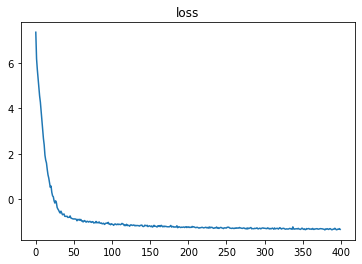

In [16]:
def mask_operation(i, n):
    return i < (n + MIN_N)
    
class CaptchaModel(nn.Module):
    """
    network, model and guide wrapper class
    """
    def __init__(self, use_cuda=False):
        super().__init__()
        self.num_char_domain = torch.arange(MIN_N, MAX_N + 1)
        if use_cuda:
            self.num_char_domain = self.num_char_domain.cuda()

        #self.numNet = NumNet((captchaHeight, captchaWidth), len(self.num_char_domain))
        #self.noiseNet = NoiseNet((captchaHeight, captchaWidth), 1)
        self.char_dict = char_dict # letter dictionary
        self.charNet = CharNetSingle((captchaHeight, captchaWidth), len(self.char_dict), max(self.num_char_domain)) # with noise
        self.inputEmbedding = InputEmbedding((captchaHeight, captchaWidth), len(self.char_dict), max(self.num_char_domain))
        self.noise_constraint = torch.distributions.constraints.interval(MIN_NOISE, MAX_NOISE)
        self.hid_net = simpleNN(hidden_state_dim + len(char_dict) + MAX_N + 1, hidden=128, out_size = hidden_state_dim, t = "mlp")
        self.h0 = nn.Parameter(torch.zeros(hidden_state_dim))
        
        input_dim_dict = {
            "img" : captchaHeight * captchaWidth,
        }
        var_dim_dict = {
            "num_char" : 1,
            "noise" : 1,
        }
        
        dependency_dict = {
            "num_char" : ["img"],
            "noise" : ["img"],
        }
        
        to_event_dict = {
            "num_char" : 0,
            "noise" : 1,
        }
        
        dist_type_dict = {
            "num_char" : ("cate", len(self.num_char_domain)),
            "noise" : "norm"
        }
        
        self.gmade_n = GMADE(input_dim_dict, dependency_dict, var_dim_dict, 
           dist_type_dict, to_event_dict, use_cuda=use_cuda, hidden_layers=3, hidden_sizes=1)
        
        self.noise_dim = 128
        
        input_dim_dict = {
            "img_embedded" : 1280,
            "hid" : hidden_state_dim,
            "noise" : self.noise_dim
        }
        
        var_dim_dict = {
            "char" : 1, 
        }
        
        dependency_dict = {
            "char" : ["img_embedded", "hid", "noise"]
        }
        
        to_event_dict = {
            "char" : 0
        }
        
        dist_type_dict = {
           "char" : ("cate", len(self.char_dict))
        }
        
        #self.gmade_char = GMADE(input_dim_dict, dependency_dict, var_dim_dict, 
        #   dist_type_dict, to_event_dict, use_cuda=use_cuda, hidden_layers=3, hidden_sizes=3)
            
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
    
    def _map_to_noise_range(self, input):
        """
        map input number to the valid noise range
        """
        input = torch.distributions.transform_to(self.noise_constraint)(input)
        return input

    # update from old captcha model/guide:
    # using mask to zero out index > num_char, this is a generalization of the previous version where we take the mean 
    # and assume num_char is the same for the entire batch

    def guide(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        img = observations["captcha"].float()
        BS = img.shape[0]
        
        # posterior to the number of letters
        
        with pyro.plate("data", img.shape[0]):
            prob = self.numNet(img)
            #prob = torch.mean(prob, dim=0)
            N_index = pyro.sample("num_char", dist.Categorical(prob).to_event(0))
            N_index = torch.add(N_index, self.num_char_domain[0])
            
            # posterior to the noise
            noise_mean, noise_sig, noise_map = self.noiseNet(img)
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            input_emb = self.inputEmbedding(img, noise_map)
            h = self.h0.expand(BS, -1)
            
            for i in range(MAX_N):
                # tranform index to one-hot representation
                i_input = torch.tensor(i)
                if USE_CUDA:
                    i_input = i_input.cuda()
                i_input = F.one_hot(i_input, num_classes=MAX_N).float()
                i_input = i_input.repeat(BS, 1)
                # whether the character has ends
                sample_mask = i < N_index
                charP_i = self.charNet(input_emb, h, noise_batch)
                c_i = pyro.sample("char_{}".format(i), dist.Categorical(charP_i).mask(sample_mask).to_event(0))
                c_i = F.one_hot(c_i, num_classes=len(self.char_dict)).float()
                # update the hidden state
                h = self.hid_net([h, c_i, i_input, sample_mask.float().unsqueeze(1)])
                
    def guide_gmade(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        
        img = observations["captcha"].float()
        BS = img.shape[0]
        # flatten representation of img
        img_raw = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
                
        with pyro.plate("data", img.shape[0]):
            
            input_dict = {
                "img" : img_raw
            }
            out_1 = self.gmade_n(input_dict, suffix="")
            N_index = out_1["num_char"]
            N_index = torch.add(N_index, self.num_char_domain[0])
            noise_batch = out_1["noise"]
            noise_batch = self._map_to_noise_range(noise_batch)
            input_emb = self.inputEmbedding(img, None)
            h = self.h0.expand(BS, -1)
            #print(N_index, noise_batch)
            #noise_batch = noise_batch.repeat(1, self.noise_dim)
            for i in range(MAX_N):
                # tranform index to one-hot representation
                i_input = torch.tensor(i)
                if USE_CUDA:
                    i_input = i_input.cuda()
                i_input = F.one_hot(i_input, num_classes=MAX_N).float()
                i_input = i_input.repeat(BS, 1)
                # whether the character has ends
                sample_mask = i < N_index
                charP_i = self.charNet(input_emb, h, noise_batch)
                c_i = pyro.sample("char_{}".format(i), dist.Categorical(charP_i).mask(sample_mask).to_event(0))
                c_i = F.one_hot(c_i, num_classes=len(self.char_dict)).float()
                # update the hidden state
                h = self.hid_net([h, c_i, i_input, sample_mask.float().unsqueeze(1)])
                
    def guide_gmade_rec(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        
        img = observations["captcha"].float()
        BS = img.shape[0]
        # flatten representation of img
        img_raw = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
                
        with pyro.plate("data", img.shape[0]):
            
            input_dict = {
                "img" : img_raw
            }
            out_1 = self.gmade_n(input_dict, suffix="")
            N_index = out_1["num_char"]
            N_index = torch.add(N_index, self.num_char_domain[0])
            noise_batch = out_1["noise"]
            noise_batch = self._map_to_noise_range(noise_batch)
            input_emb = self.inputEmbedding(img, None)
            h = self.h0.expand(BS, -1)
            #print(N_index, noise_batch)
            #noise_batch = noise_batch.repeat(1, self.noise_dim)
            
            def _rec(i, h):
                if i < MAX_N:
                    i_input = torch.tensor(i)
                    if USE_CUDA:
                        i_input = i_input.cuda()
                    i_input = F.one_hot(i_input, num_classes=MAX_N).float()
                    i_input = i_input.repeat(BS, 1)
                    # whether the character has ends
                    sample_mask = i < N_index
                    charP_i = self.charNet(input_emb, h, noise_batch)
                    c_i = pyro.sample("char_{}".format(i), dist.Categorical(charP_i).mask(sample_mask).to_event(0))
                    c_i = F.one_hot(c_i, num_classes=len(self.char_dict)).float()
                    # update the hidden state
                    h = self.hid_net([h, c_i, i_input, sample_mask.float().unsqueeze(1)])
                    _rec(i + 1, h)
            _rec(0, h)
                    
#             for i in range(MAX_N):
#                 # tranform index to one-hot representation
#                 i_input = torch.tensor(i)
                
#                 # whether the character has ends
#                 sample_mask = i < N_index
                
#                 input_dict_char = {
#                     "img_embedded" : input_emb,
#                     "hid" : h,
#                     "noise" : noise_batch
#                 }
#                 out_2 = self.gmade_char(input_dict_char, suffix="_"+str(i), mask_dict={"char" : sample_mask})
#                 c_i = out_2["char"]
#                 c_i = F.one_hot(c_i, num_classes=len(self.char_dict)).float()
#                 h = self.hid_net([h, c_i, i_input, sample_mask.float().unsqueeze(1)])

            
    def model(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        
        BS = observations["captcha"].shape[0]
        
        with pyro.plate("data", BS):
            
            
            num_p = torch.tensor(1 / len(self.num_char_domain)).repeat(len(self.num_char_domain)).unsqueeze(0).repeat(BS, 1)
        
            if self.use_cuda:
                num_p = num_p.cuda()

            # sample the number of characters
            N_index = pyro.sample("num_char", dist.Categorical(num_p).to_event(0))
            
            N_index = torch.add(N_index,  self.num_char_domain[0])
            
            noise_mean = torch.tensor((MAX_NOISE - MIN_NOISE) / 2).repeat((BS, 1))
            noise_sig = torch.tensor(0.5).repeat((BS, 1))

            if self.use_cuda:
                noise_mean = noise_mean.cuda()
                noise_sig = noise_sig.cuda()

            # sample the noise
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            
            sampled_c = []
            for i in range(MAX_N):
                sample_mask = i < N_index
                num_c_i = torch.tensor(1 / len(self.char_dict)).repeat((BS, len(self.char_dict)))
                if self.use_cuda:
                    num_c_i = num_c_i.cuda()
                c_i = pyro.sample("char_{}".format(i), dist.Categorical(num_c_i).mask(sample_mask).to_event(0))
                sampled_c.append((sample_mask, c_i))
            # sample characters
            rendered_images = []
            for i in range(BS):
                chars = ""
                for j in range(MAX_N):
                    if sampled_c[j][0][i]:
                        chars += self.char_dict[sampled_c[j][1][i]]
                    else:
                        break
                rendered_image = render_image(chars, noise=float(noise_batch[i]), use_cuda=self.use_cuda)
                rendered_images.append(rendered_image)
                
        rendered_images = torch.stack(rendered_images)
        sigma = torch.tensor(0.000001)
        #print(rendered_images)
        if self.use_cuda:
                sigma = sigma.cuda()

        pyro.sample("captcha", dist.Normal(rendered_images, sigma).to_event(2), obs=observations["captcha"])
    
    def model_rec(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        
        BS = observations["captcha"].shape[0]
        
        with pyro.plate("data", BS):
            
            
            num_p = torch.tensor(1 / len(self.num_char_domain)).repeat(len(self.num_char_domain)).unsqueeze(0).repeat(BS, 1)
        
            if self.use_cuda:
                num_p = num_p.cuda()

            # sample the number of characters
            N_index = pyro.sample("num_char", dist.Categorical(num_p).to_event(0))
            
            N_index = torch.add(N_index,  self.num_char_domain[0])
            
            noise_mean = torch.tensor((MAX_NOISE - MIN_NOISE) / 2).repeat((BS, 1))
            noise_sig = torch.tensor(0.5).repeat((BS, 1))

            if self.use_cuda:
                noise_mean = noise_mean.cuda()
                noise_sig = noise_sig.cuda()

            # sample the noise
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            
            sampled_c = []
            
            def _rec(i):
                if i < MAX_N:
                    sample_mask = i < N_index
                    num_c_i = torch.tensor(1 / len(self.char_dict)).repeat((BS, len(self.char_dict)))
                    if self.use_cuda:
                        num_c_i = num_c_i.cuda()
                    c_i = pyro.sample("char_{}".format(i), dist.Categorical(num_c_i).mask(sample_mask).to_event(0))
                    sampled_c.append((sample_mask, c_i))
                    _rec(i + 1)
            _rec(0)
                
            # sample characters
            rendered_images = []
            
            # does not contain any sample statements
            def _render_imgs(i):
                
                def _get_chars(j, chars, i):
                    if j < MAX_N:
                        if sampled_c[j][0][i]:
                            chars += self.char_dict[sampled_c[j][1][i]]
                            return _get_chars(j + 1, chars, i)
                    return chars
                if i < BS:
                    chars = ""
                    chars = _get_chars(0, "", i)
                    #print("chars", chars)
                    rendered_image = render_image(chars, noise=float(noise_batch[i]), use_cuda=self.use_cuda)
                    rendered_images.append(rendered_image)
                    _render_imgs(i + 1)
                    
            _render_imgs(0)
                    
#             for i in range(BS):
#                 chars = ""
#                 for j in range(MAX_N):
#                     if sampled_c[j][0][i]:
#                         chars += self.char_dict[sampled_c[j][1][i]]
#                     else:
#                         break
#                 rendered_image = render_image(chars, noise=float(noise_batch[i]), use_cuda=self.use_cuda)
#                 rendered_images.append(rendered_image)
                
        rendered_images = torch.stack(rendered_images)
        sigma = torch.tensor(0.000001)
        if self.use_cuda:
                sigma = sigma.cuda()

        pyro.sample("captcha", dist.Normal(rendered_images, sigma).to_event(2), obs=observations["captcha"])

captchaModel = CaptchaModel(USE_CUDA)

optimiser = pyro.optim.Adam({'lr': 5e-5})
csis = pyro.infer.CSIS(captchaModel.model_rec, captchaModel.guide_gmade_rec, optimiser, num_inference_samples=1)

optimize(1, USE_CUDA)
# test_cycle(USE_CUDA)
save_metric_to_disk("captcha_metrics_noise_in_charnet_gmade_400_noise_rec_gmade_charnet.json")


Logs